This notebook explains how we can go about explore and prepare data for model building.The notebook is structured in the following way 

 - About Dataset
 - Data Summary
 - Feature Engineering
 - Missing Value Analysis
 - Outlier Analysis
 - Correlation Analysis
 - Visualizing Distribution Of Data
 - Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)
 - Filling 0's In Windspeed Using Random Forest
 - Linear Regression Model
 - Regularization Models
 - Ensemble Models

## About Dataset

#### **Overview**

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

In [287]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **Lets Read In The Dataset**

In [288]:
dailyData = pd.read_csv("./input/train2023.csv")

## Data Summary

As a first step lets do three simple steps on the dataset

 - Size of the dataset
 - Get a glimpse of data by printing few rows of it.
 - What type of variables contribute our data

#### **Shape Of The Dataset**

In [289]:
dailyData.shape

(10886, 12)

#### **Sample Of First Few Rows**

In [290]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2022-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2022-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


#### **Variables Data Type**

In [291]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

 - Create new columns "date,"hour","weekDay","month" from "datetime"
   column.
 - Coerce the datatype of "season","holiday","workingday" and weather to category.
 - Drop the datetime column as we already extracted useful features from it.

#### **Creating New Columns From "Datetime" Column**

In [292]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

#### **Coercing To Category Type**

In [293]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

#### **Dropping Unncessary Columns**

In [294]:
dailyData  = dailyData.drop(["datetime"],axis=1)

#### **Lets Start With Very Simple Visualization Of Variables DataType Count**

[Text(0.5, 0, 'Variable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables DataType Count')]

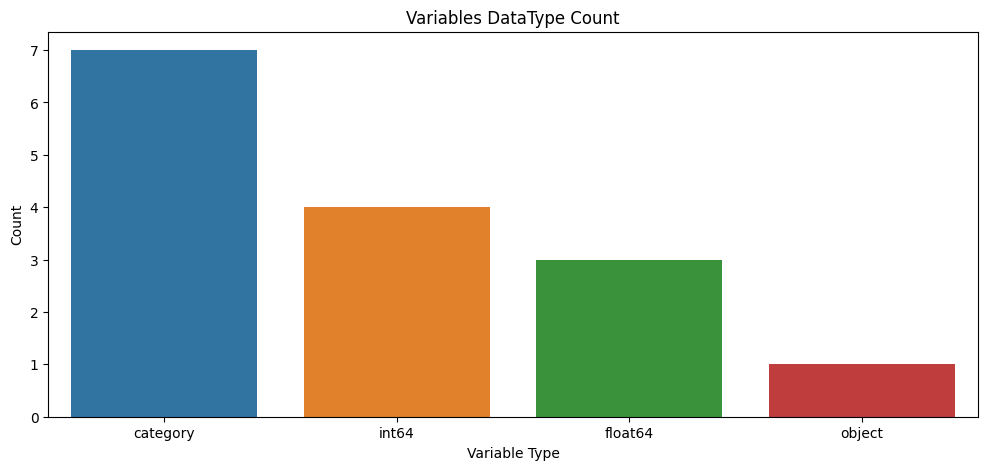

In [295]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.astype(str).value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables DataType Count")


## Missing Values Analysis

Once we get hang of the data and columns, next step we geneally is to find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno".

Its a quiet handy library to quickly visualize variables for missing values. As I mentioned earlier we got lucky this time as there no missing value in the dataset.

## Skewness In Distribution ##

<Axes: >

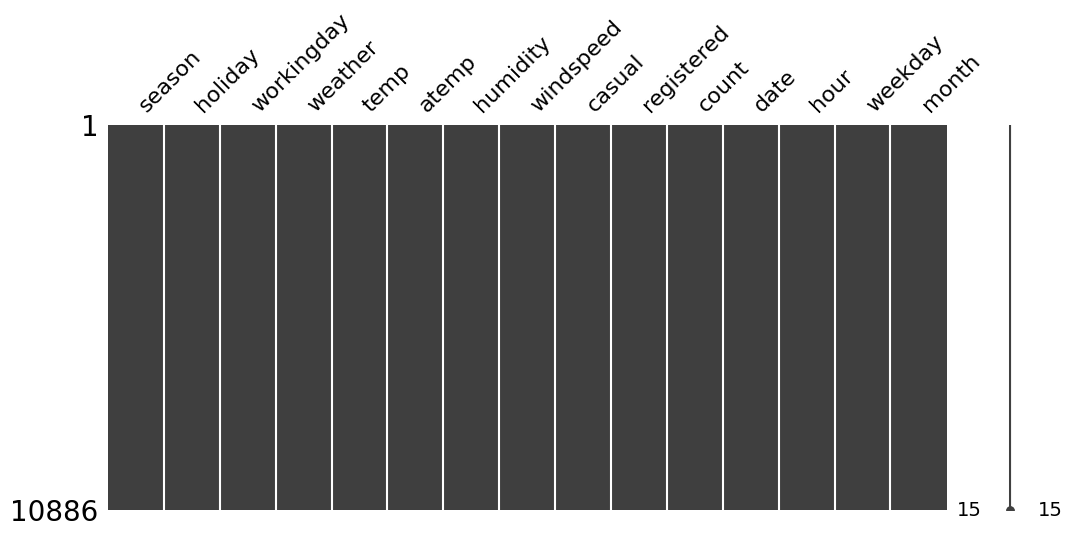

In [296]:
msno.matrix(dailyData,figsize=(12,5))

## Outliers Analysis

At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

 - Spring season has got relatively lower count.The dip in median value
   in boxplot gives evidence for it.
 - The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time. 
 - Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

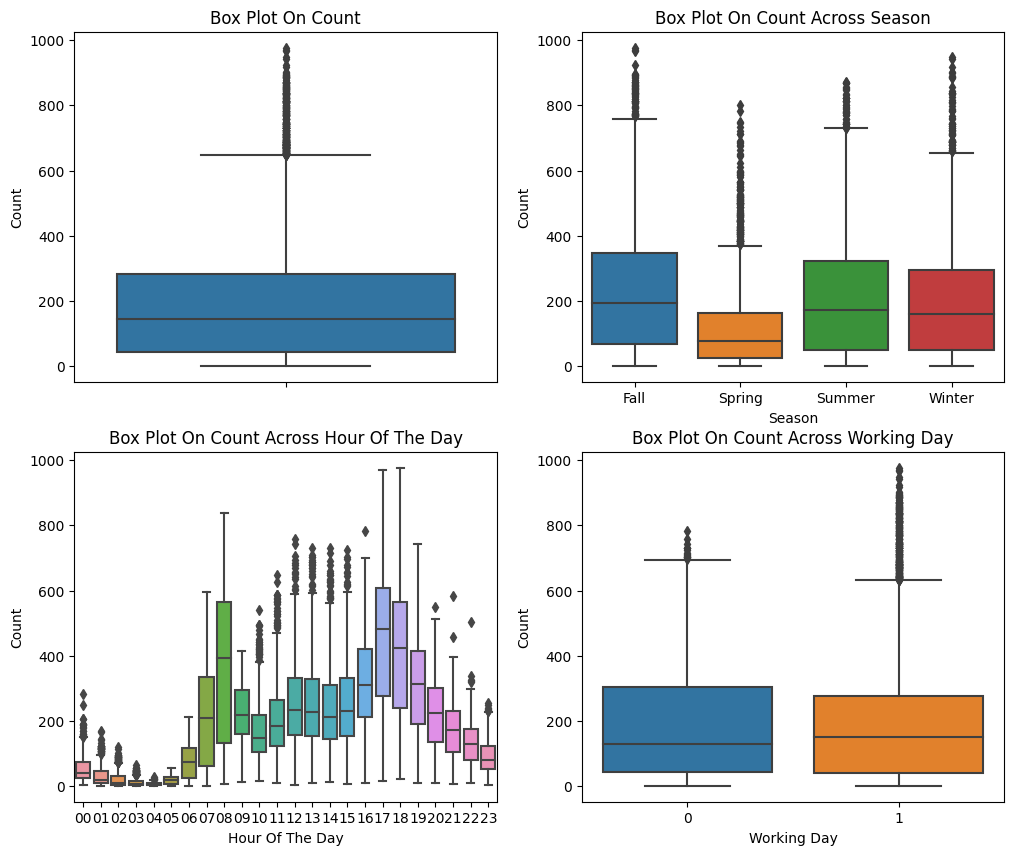

In [297]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **Lets Remove Outliers In The Count Column**

In [298]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [299]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


## Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

 - temp and humidity features has got positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has got little dependency on
   "temp" and "humidity".
 - windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
 - "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

<Axes: >

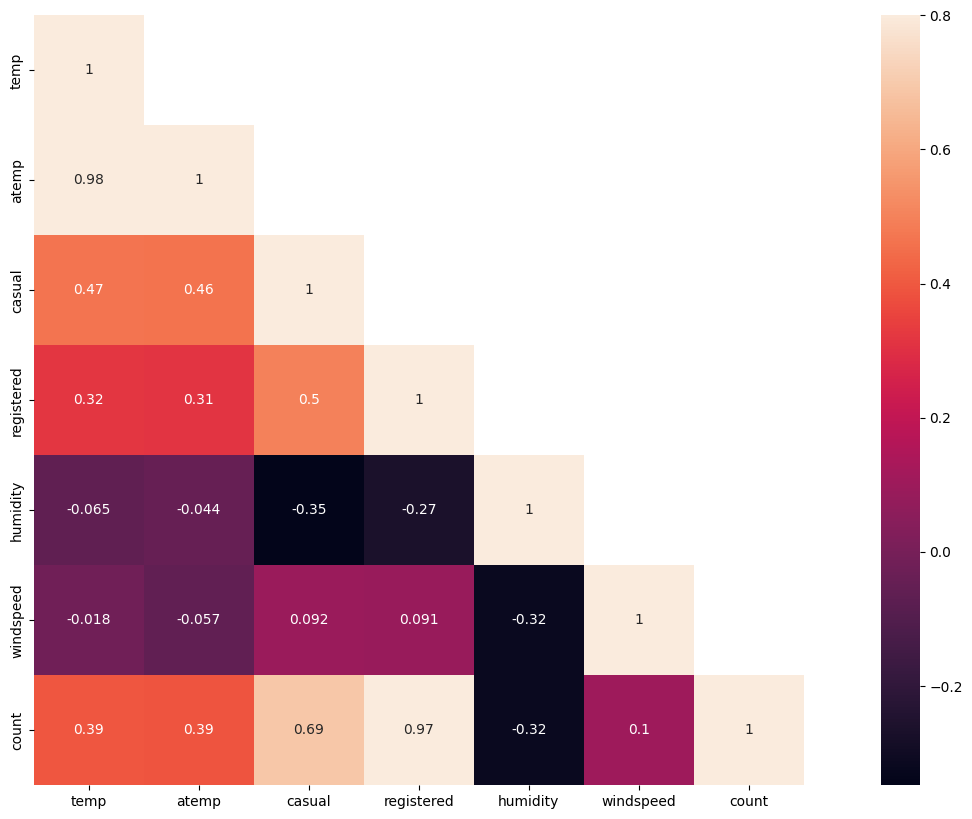

In [300]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<Axes: xlabel='humidity', ylabel='count'>

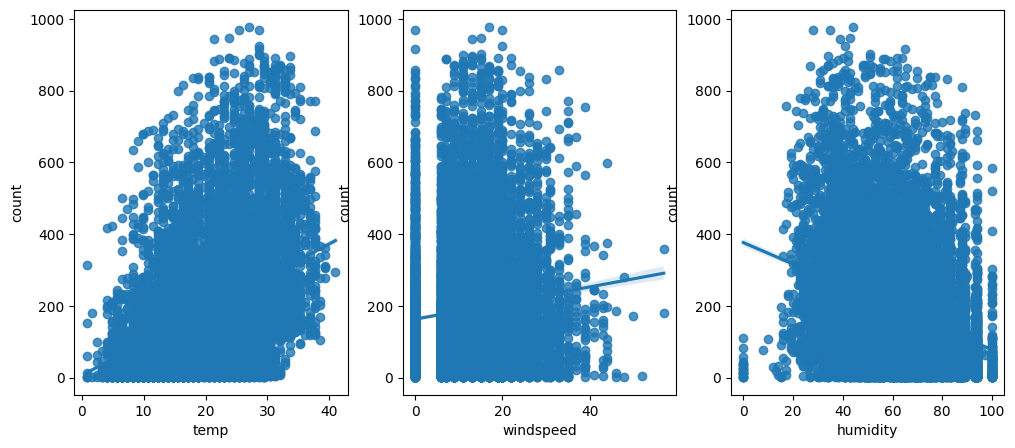

In [301]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

## Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

C:\Users\Joe.Robertson\AppData\Local\Temp\ipykernel_23544\4097800041.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(dailyData["count"],ax=axes[0][0])
C:\Users\Joe.Robertson\AppData\Local\Temp\ipykernel_23544\4097800041.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(np.log(dailyDataWithou

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229774, 4.562423868087808, 0.9581176780909618))

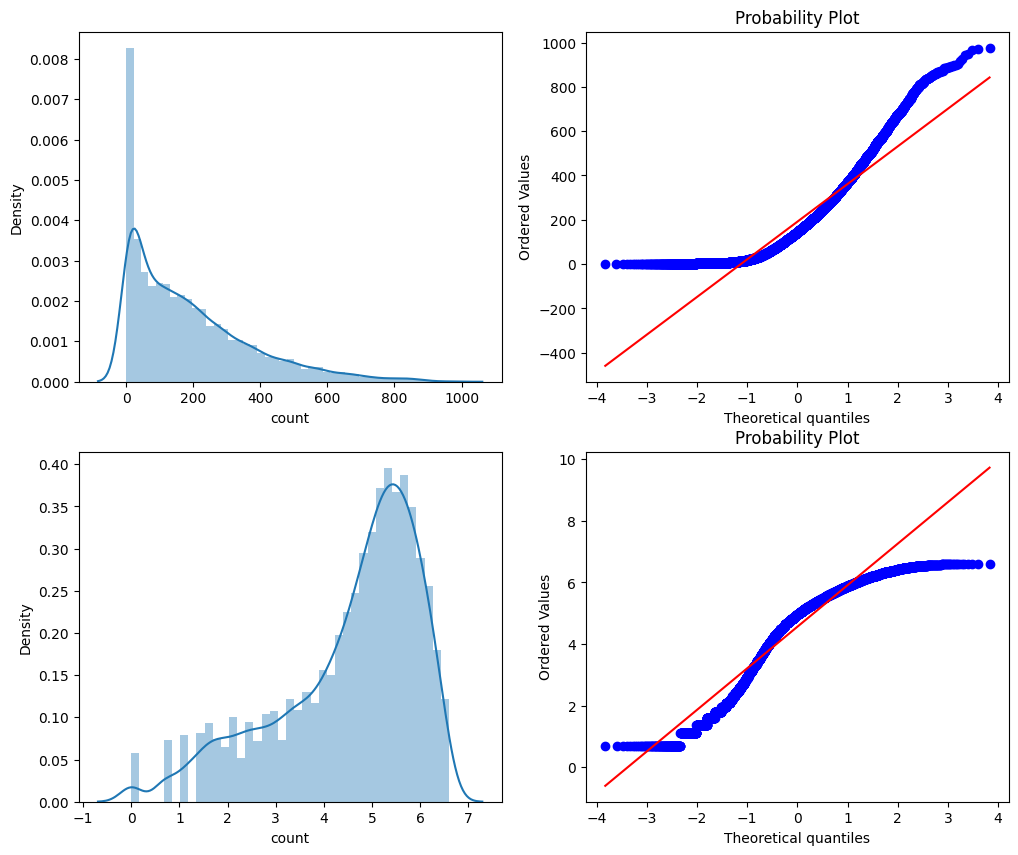

In [302]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

## Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
 - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
 - The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

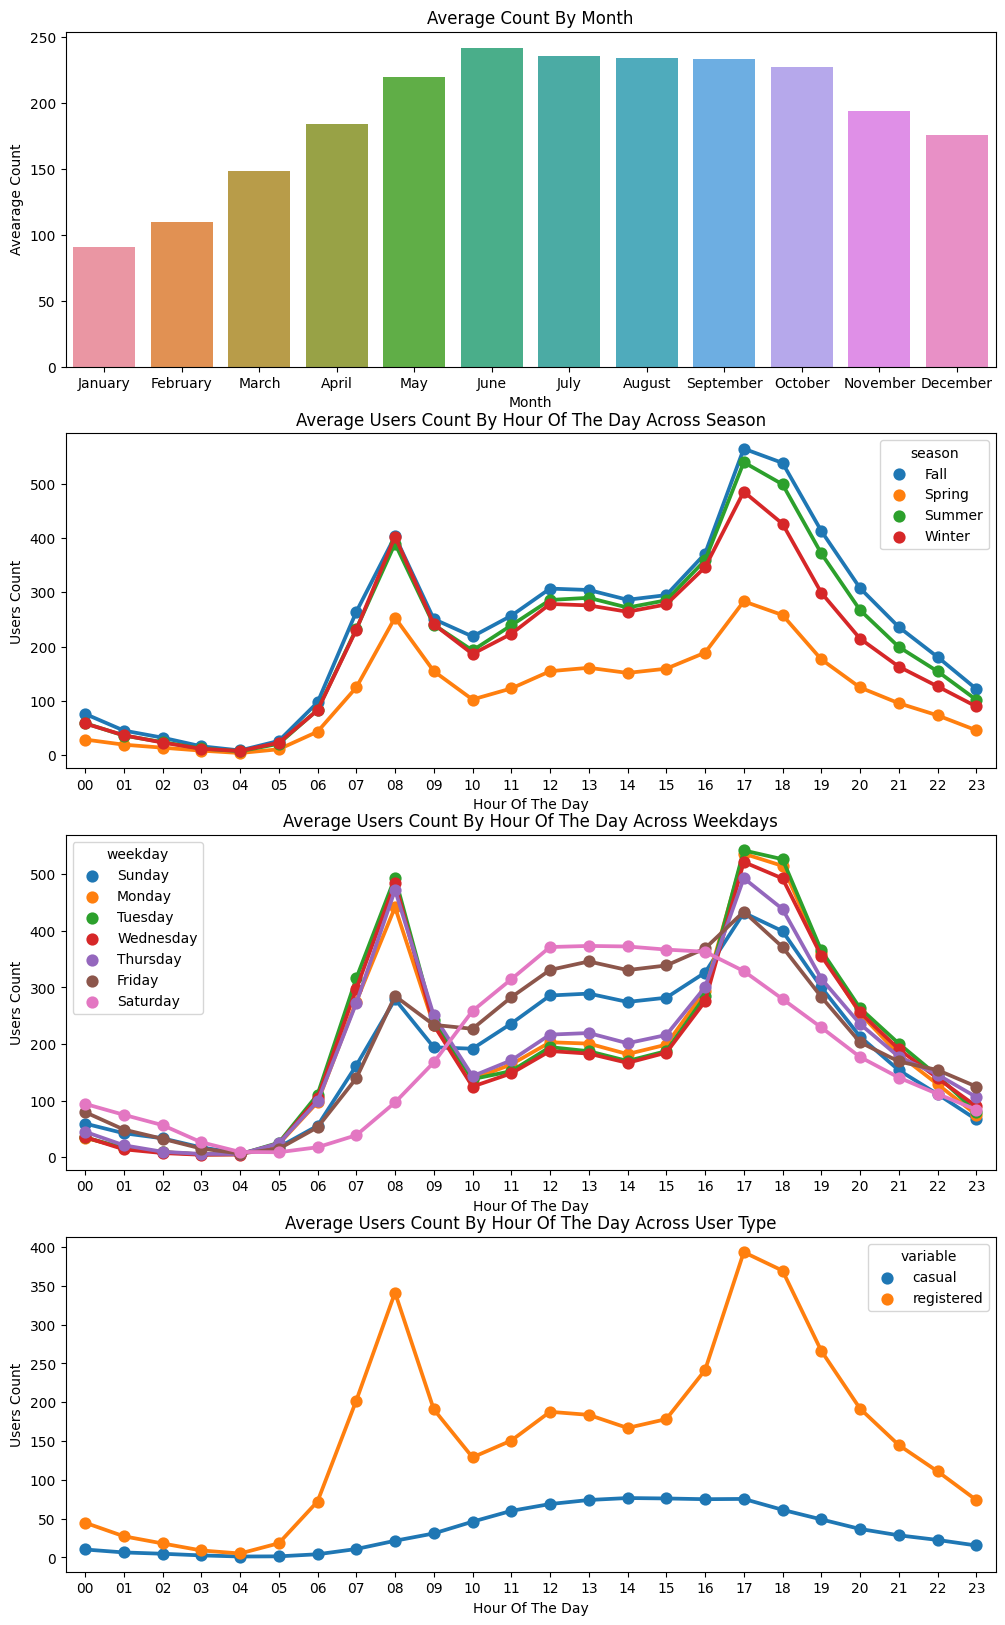

In [303]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**So we have visualized the data to a greater extent.So lets go and  build some models and see how close we can predict the results.**

## Filling 0's In windspeed Using Random Forest ##

**Lets Read In Train And Test Data**

In [304]:
dataTrain = pd.read_csv("./input/train2023.csv")
dataTest = pd.read_csv("./input/test2023.csv")

**Combine Train And Test**

In [305]:
# data = dataTrain.append(dataTest)
# data.reset_index(inplace=True)
# data.drop('index',inplace=True,axis=1)

data = pd.concat([dataTrain, dataTest])
data.reset_index(inplace=True, drop=True)


**Feature Engineering**

In [306]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

**Random Forest Model To Predict 0's In Windspeed**

In [307]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = pd.concat ([dataWindNot0, dataWind0])
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Coercing To Categorical Type**

In [308]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [309]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

**Splitting Train And Test Data**

In [310]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

**Dropping  Unncessary Variables**

In [311]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

**RMSLE Scorer**

In [312]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

##**Ensemble Models - Random Forest**##

In [313]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10558822032647008


## **Ensemble Model - Gradient Boost** ##

In [314]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
print (dataTrain.dtypes)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print (preds)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
hour          category
year          category
weekday       category
month         category
dtype: object
[2.97895866 3.46442964 3.27795997 ... 5.33705923 5.11968589 4.5647636 ]
RMSLE Value For Gradient Boost:  0.19538330408697627


**Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It  confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.**

C:\Users\Joe.Robertson\AppData\Local\Temp\ipykernel_23544\3114123267.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(yLabels,ax=ax1,bins=50)
C:\Users\Joe.Robertson\AppData\Local\Temp\ipykernel_23544\3114123267.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(np.exp(predsTest),ax=ax2,bins=50

<Axes: ylabel='Density'>

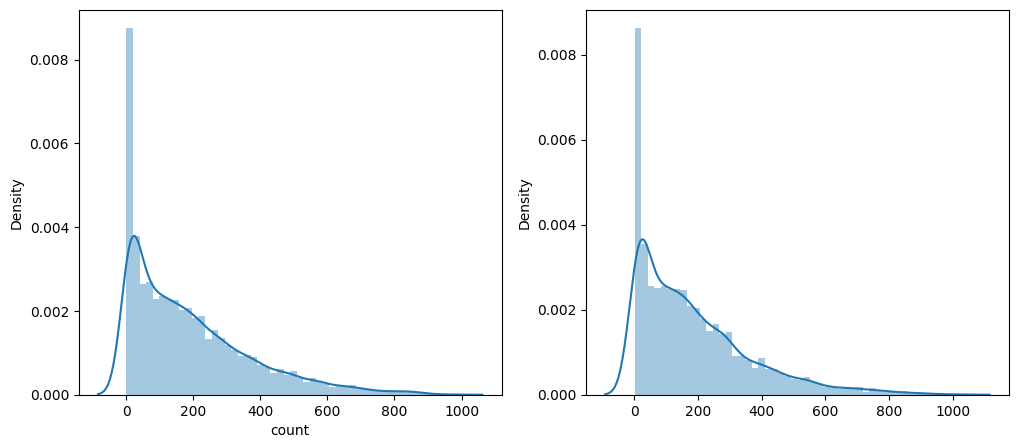

In [315]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [316]:
print (dataTrain.head())

      season holiday workingday weather  temp   atemp  humidity  windspeed   
15199      1       0          0       1  9.84  14.395        81   6.982137  \
15200      1       0          0       1  9.02  13.635        80   6.747637   
15201      1       0          0       1  9.02  13.635        80   6.747637   
15202      1       0          0       1  9.84  14.395        75   6.712127   
15203      1       0          0       1  9.84  14.395        75   6.712127   

      hour  year weekday month  
15199    0  2022       5     1  
15200    1  2022       5     1  
15201    2  2022       5     1  
15202    3  2022       5     1  
15203    4  2022       5     1  


In [317]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType

# Define the columns to use for the different preprocessing steps
categorical_cols = ["season", "holiday", "workingday", "weather", "hour", "year", "weekday", "month"]
numerical_cols = ["temp", "atemp", "humidity", "windspeed"]

# Create the transformers for the categorical and numerical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine the transformers using a ColumnTransformer object
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

# Create the final pipeline by adding the preprocessing steps and the GradientBoostingRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

# Fit the pipeline
pipeline.fit(dataTrain, yLabelsLog)

# Define input data types
input_data = [('season', Int64TensorType([1, 1])),
              ('holiday', Int64TensorType([1, 1])),
              ('workingday', Int64TensorType([1, 1])),
              ('weather', Int64TensorType([1, 1])),
              ('temp', FloatTensorType([1, 1])),
              ('atemp', FloatTensorType([1, 1])),
              ('humidity', FloatTensorType([1, 1])),
              ('windspeed', FloatTensorType([1, 1])),
              ('hour', Int64TensorType([1, 1])),
              ('year', Int64TensorType([1, 1])),
              ('weekday', Int64TensorType([1, 1])),
              ('month', Int64TensorType([1, 1]))]

# Convert model to ONNX format
onnx_model = convert_sklearn(pipeline, 'Pipeline', input_data, target_opset=16)

# Save ONNX model to file
with open('gradient_boosting_regressor.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())


In [318]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
sess = ort.InferenceSession('gradient_boosting_regressor.onnx')

# Define input data
input_data = {
    'season': np.array([[1]]).astype(np.int64),
    'holiday': np.array([[0]]).astype(np.int64),
    'workingday': np.array([[0]]).astype(np.int64),
    'weather': np.array([[1]]).astype(np.int64),
    'temp': np.array([[9.84]]).astype(np.float32),
    'atemp': np.array([[14.395]]).astype(np.float32),
    'humidity': np.array([[81]]).astype(np.float32),
    'windspeed': np.array([[6.632263]]).astype(np.float32),
    'hour': np.array([[0]]).astype(np.int64),
    'year': np.array([[2011]]).astype(np.int64),
    'weekday': np.array([[5]]).astype(np.int64),
    'month': np.array([[1]]).astype(np.int64)
    }

output = sess.run(None, input_data)
print(output)
print (np.exp(output))



[array([[3.6213408]], dtype=float32)]
[[[37.38766]]]


In [319]:
import onnx
import numpy as np

# Load the ONNX model
model = onnx.load('gradient_boosting_regressor.onnx')

# Create a new graph with an output node that applies the Exp function
output_name = model.graph.output[0].name
new_output_name = 'output_exp'
new_output_type = model.graph.output[0].type
new_output_type.tensor_type.elem_type = 1  # set the output type to float
exp_node = onnx.helper.make_node('Exp', [output_name], [new_output_name])
new_output = onnx.helper.make_tensor_value_info(
    name=new_output_name, 
    elem_type=onnx.TensorProto.FLOAT, 
    shape=[None, 1]
)
model.graph.node.append(exp_node)
model.graph.output[0].CopyFrom(new_output)

# Save the modified ONNX model
onnx.save(model, 'gradient_boosting_regressor_exp.onnx')


In [320]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
sess = ort.InferenceSession('gradient_boosting_regressor_exp.onnx')

# Define input data
input_data = {
    'season': np.array([[1]]).astype(np.int64),
    'holiday': np.array([[0]]).astype(np.int64),
    'workingday': np.array([[0]]).astype(np.int64),
    'weather': np.array([[1]]).astype(np.int64),
    'temp': np.array([[9.84]]).astype(np.float32),
    'atemp': np.array([[14.395]]).astype(np.float32),
    'humidity': np.array([[81]]).astype(np.float32),
    'windspeed': np.array([[6.632263]]).astype(np.float32),
    'hour': np.array([[0]]).astype(np.int64),
    'year': np.array([[2011]]).astype(np.int64),
    'weekday': np.array([[5]]).astype(np.int64),
    'month': np.array([[1]]).astype(np.int64)
    }

output = sess.run(None, input_data)
print(output)
print (np)


[array([[37.38766]], dtype=float32)]
<module 'numpy' from 'c:\\Users\\Joe.Robertson\\Documents\\ML\\bike_forecasting_kaggle\\.venv\\lib\\site-packages\\numpy\\__init__.py'>
